In [2]:
from TMP117 import TMP117
from MPU6050 import MPU6050
from TP import TP
from plotAll import generateActiveList
#this is a test

In [3]:
import random
import numpy as np
from IPython.display import display, Image

# Temperature Sensor Configurations

***Continuous conversion mode:*** The device continuously performs temperature conversions in this mode, as shown in Figure 7-3, and updates the temperature result register at the end of every active conversion  
***One-shot mode:*** After the device completes a (temperature conversion) one-shot conversion, the device goes to the *low-power shutdown mode*.  

### Parameters for TMP117 (to be changed by teams)  
...add more explanation of what each input does later  
add explanation of what possible inputs including default are for each input ...  

**Continuous conversion (if selected) params**:  
**possible conversion cycle times (see column 1 of table below)**: 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16  
**possible averaging inputs**: 0, 8, 32, 64


In [4]:
#Image("convTimes.png")

#### TO-DO (teams set inputs)

In [5]:
time_step = 0.0155
duration = 100

# params to set, CONV CYCLE TIME > TIME INTERVAL
# time1 = (0, 50)
# numaverage1 = 0
# convCycleTime1 = 16
# mode1 = "OS"

# time2 = (60, 75)
# numaverage2 = 8
# convCycleTime2 = 0.0155
# mode2 = "CC"

# time3 = (85, 97)
# numaverage3 = 8
# convCycleTime3 = 8
# mode3 = "CC"

activeTimeParams = [(0, 15, "OS_8_0.0155"), (30, 45, "CC_32_16"), (70, 75, "OS_64_16")]
#activeTimeParams = { time1: [numaverage1, convCycleTime1, mode1], time2: [numaverage2, convCycleTime2, mode2], time3: [numaverage3, convCycleTime3, mode3]  }

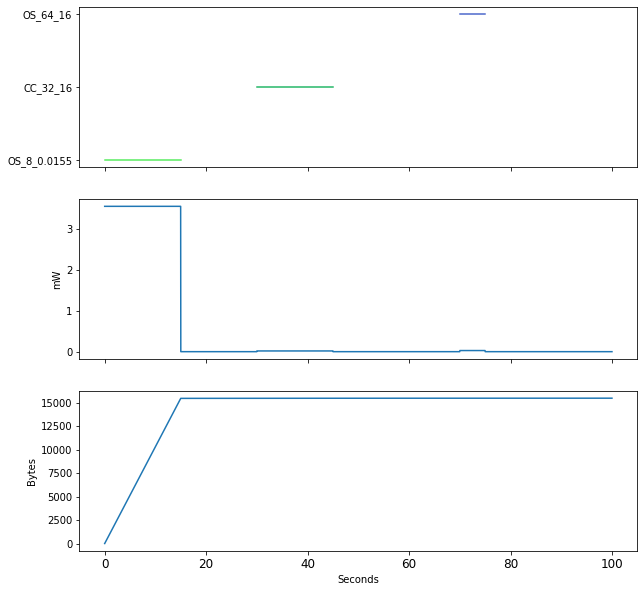

In [6]:
tmp1 = TMP117(time_step, duration, activeTimeParams) # creating TMP117 class
tmp1.Simulation()

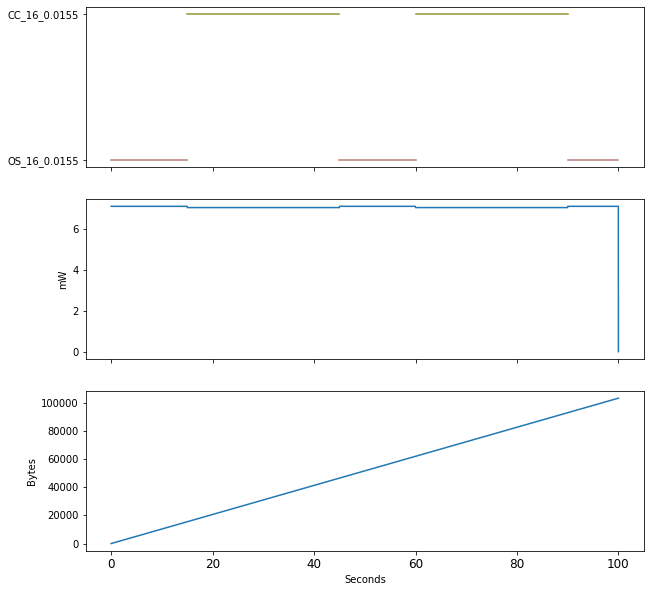

In [7]:
modedict = {"OS_16_0.0155": 15, "CC_16_0.0155":30}
activeTimeParams = generateActiveList(duration, modedict=modedict)
tmp2 = TMP117(time_step, duration, activeTimeParams)
tmp2.Simulation()

# Accelerometer configurations

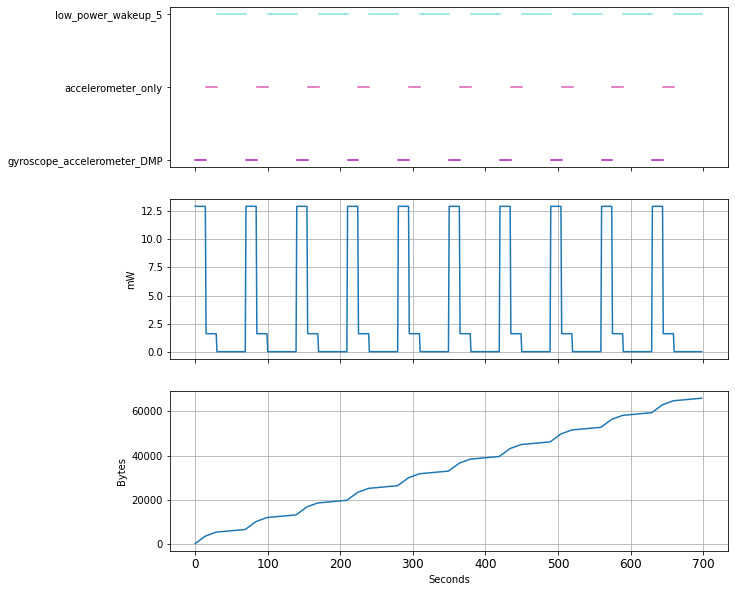

1

In [8]:
modedict = {"gyroscope_accelerometer_DMP":15, "accelerometer_only":15,"low_power_wakeup_5":40}
active_times = generateActiveList(total_time=699, modedict=modedict)
accel2 = MPU6050(time_step=1, duration=699, loop_rate=20, digital_low_pass=0, sample_rate_divisor=0)

accel2.runSim(active_times)

Thermopile

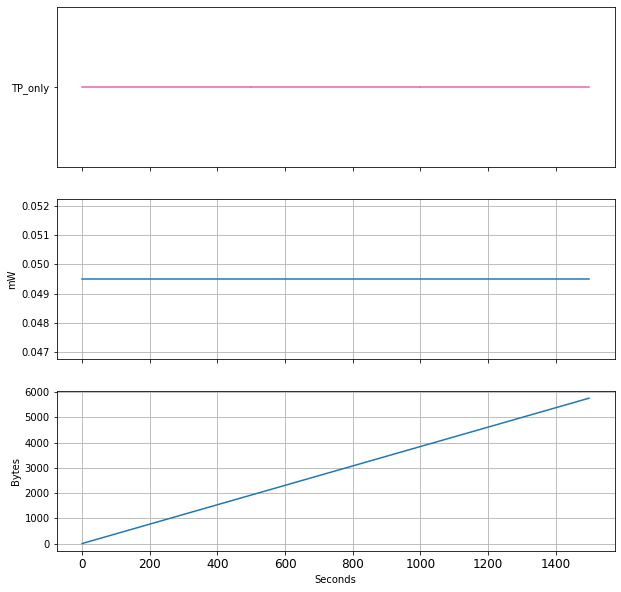

1

In [9]:
from TP import TP
Thermo = TP(time_step=1, duration=1500, loop_rate=20)
active_times = [(0,500,"TP_only"), (500,1000,"TP_only"), (1000,1500,"TP_only")]
Thermo.runSim(active_times)